# TM10007 Assignment: Prediction of Tumor Grade in Brain Cancer

Group 4: Kiefer Comassi (4402359), Myrthe van Haaften (4547470), Frédérique Koopman (4470885), Stephanie Stoutjesdijk (4557808)


## Installing and importing functions and packages

In [124]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
#!pip install missingpy

In [126]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt

from scipy.stats import shapiro, uniform
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFECV, SelectKBest, f_classif, SelectFromModel
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from missingpy import KNNImputer

from brats.load_data import load_data

## Loading and splitting data 

In [128]:
# Load data
data = load_data()

# Splitting feature values and patient labels
FEATURES = data.drop(columns=['label'])
LABELS = data['label']

GBM = FEATURES.loc[LABELS=='GBM']
LGG = FEATURES.loc[LABELS=='LGG']


## Preprocessing before crossvalidation

Overview of the NaN's in the dataset

In [130]:
# Determining the number of NaN's
NO_NAN_ROW_TOTAL = FEATURES.isnull().sum(axis=1)             # Number of NaN's per patient for GBM and LGG patients
NO_NAN_COL_TOTAL = FEATURES.isnull().sum(axis=0)             # Number of NaN's per feature for GBM and LGG patients

GBM_NO_NAN_COL = GBM.isnull().sum(axis=0)                    # Number of NaN's per feature for GBM patients
LGG_NO_NAN_COL = LGG.isnull().sum(axis=0)                    # Number of NaN's per feature for LGG patients
OVERVIEW_NAN = { 'Total': NO_NAN_COL_TOTAL, 'GBM': GBM_NO_NAN_COL, 'LGG': LGG_NO_NAN_COL } 


Feature selection based on the number of NaN's. Threshold = the maximum number of NaN's in a column

In [132]:
# Define percentage of patients with no data for a certain feature, above which the feature is discarded
PERC_MISSING_GBM = 30
PERC_MISSING_LGG = 30

# Determining threshold for discarding feature based on above percentage
THRESHOLD_GBM = floor((PERC_MISSING_GBM/100) * len(GBM.index))
THRESHOLD_LGG = floor((PERC_MISSING_LGG/100) * len(LGG.index))

# Initialisation
FEATURES_REMOVED = []

# Append names of features that should be discarded to list

for feature in GBM_NO_NAN_COL[GBM_NO_NAN_COL > THRESHOLD_GBM].index[:]:
    FEATURES_REMOVED.append(feature)

for feature in LGG_NO_NAN_COL[LGG_NO_NAN_COL > THRESHOLD_LGG].index[:]:
    FEATURES_REMOVED.append(feature)

# Remove features from dataset
DATA_FEAT_SEL = FEATURES.drop(columns=[features for features in set(FEATURES_REMOVED)])

# The variables (series) below 'bins' the NaN's:
# - the index column is the amount of NaN's in the dataset 
# - the second column is the amount of features that have this amount of NaN's

#aantal_NAN_GBM = GBM_no_nan_col.value_counts()
#aantal_NAN_LGG = LGG_no_nan_col.value_counts()
#aantal_NAN_total = no_nan_col.value_counts()
print(f'{len(DATA_FEAT_SEL.columns)}/{len(FEATURES.columns)} features are left in dataset')

482/724 features are left in dataset


Patient selection based on the number of NaN's. Threshold = the maximum number of NaN's in a row.

In [134]:
# Patient selection 

# Percentage/number of features that a patient is allowed to miss. When above this amount, this patient is removed from the trainingset, because it is missing too many features. 
PERC_MISSING_SAMPLE = 30

# Make the threshold
THRESHOLD_SAMPLE = floor((PERC_MISSING_SAMPLE/100) * len(DATA_FEAT_SEL.columns))

# Number of NaN's per patient AFTER removing some features
NO_NAN_ROW_TRAIN = DATA_FEAT_SEL.isnull().sum(axis=1)      

# Make an empty list, which will be filled with samples that are above the threshold
SAMPLES_REMOVED = [] 
LABELS_SEL = LABELS

# Looping over the trainingset to determine which patients are above the threshold, and remove them directly.
print('The following sample(s) is/are removed from dataset:')
for sample in NO_NAN_ROW_TRAIN[NO_NAN_ROW_TRAIN > THRESHOLD_SAMPLE].index[:]:
    if sample:
        print(sample)
        SAMPLES_REMOVED.append(sample)      # This should be removed in combination with the comment before
        DATA_FEAT_SEL = DATA_FEAT_SEL.drop(index=sample)
        LABELS_SEL = LABELS_SEL.drop(index=sample)

print(f'{len(DATA_FEAT_SEL)}/{len(FEATURES)} samples are left in dataset')

The following sample(s) is/are removed from dataset:
TCGA-HT-7686
166/167 samples are left in dataset


Evaluation of data distribution and outliers

In [136]:
# Evaluate data distribution: 
IMPUTER_GBM = KNNImputer(n_neighbors=5, weights="uniform")
IMPUTER_LGG = KNNImputer(n_neighbors=5, weights="uniform")        

X_GBM = DATA_FEAT_SEL[LABELS_SEL=='GBM']        
X_IMP_GBM = IMPUTER_GBM.fit_transform(X_GBM)

X_LGG = DATA_FEAT_SEL[LABELS_SEL=='LGG']        
X_IMP_LGG = IMPUTER_LGG.fit_transform(X_LGG)   

NO_NON_NORMAL_GBM = 0
FEAT_NON_NORM_GBM = list()
for index, feature in enumerate(X_IMP_GBM.T):
    t_stat, p_value = shapiro(feature)
    if p_value<0.05:
        NO_NON_NORMAL_GBM += 1 
        FEAT_NON_NORM_GBM.append(index)

NO_NON_NORMAL_LGG = 0
FEAT_NON_NORM_LGG = list()
for index, feature in enumerate(X_IMP_LGG.T):
    t_stat, p_value = shapiro(feature)
    if p_value<0.05:
        NO_NON_NORMAL_LGG += 1 
        FEAT_NON_NORM_LGG.append(index)



In [138]:

# Evaluate per GBM patient each feature
NO_OUTLIERS_GBM = 0

for patient in X_IMP_GBM:
    feat_out = 0
    for index, feature in enumerate(patient):
        q25, q75 = np.percentile(X_IMP_GBM[:,index], 25), np.percentile(X_IMP_GBM[:,index], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = ((feature>upper) | (feature<lower))
        feat_out += outlier
    if feat_out > 70:
        NO_OUTLIERS_GBM += 1

# Evaluate per LGG patient each feature
NO_OUTLIERS_LGG = 0

for patient in X_IMP_LGG:
    feat_out = 0
    for index, feature in enumerate(patient):
        q25, q75 = np.percentile(X_IMP_LGG[:,index], 25), np.percentile(X_IMP_LGG[:,index], 75)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outlier = ((feature>upper) | (feature<lower))
        feat_out += outlier
    if feat_out > 70:
        NO_OUTLIERS_LGG += 1

# Calculate mean and standard deviation per feature based on training data
#MEAN = DATA_TOTAL_IMPUTED.mean(axis=0)
#STD = DATA_TOTAL_IMPUTED.std(axis=0)

# Evaluate per patient each feature
#NO_OUTLIERS = 0
#for patient in DATA_TOTAL_IMPUTED:
#    feat_out = 0
#    for feature, mu, std in zip(patient, MEAN, STD):
#        outlier = ((feature>mu+3*std) | (feature<mu-3*std))
#        feat_out += outlier
#    if feat_out > 30:
#        no_outliers += 1

## Function definitions

Imputation

In [140]:
"""
Fit k-nearest neighbor imputer on train set and impute train and test set using this fitted imputer.
Input: 
X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
X_test : array-like, shape (n_samples, n_features)
        Test vector, where n_samples is the number of samples and
        n_features is the number of features.

Output: 
X_train_imp: array-like, shape (n_samples, n_features)
        Imputed train data.

X_test_imp: array-like, shape (n_samples, n_features)
        Imputed test data.
"""

def knn_impute_train_set(X_train, X_test):
    # Definition of imputers
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    
    # Impute train and test set 
    imputer.fit(X_train)
    X_train_imp = imputer.transform(X_train)
    X_test_imp = imputer.transform(X_test)
    return X_train_imp, X_test_imp

Scaling

In [142]:
"""
Fit MinMax scaler on train set and scale train and test set using this fitted scaler.
Input: 
X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
X_test : array-like, shape (n_samples, n_features)
        Test vector, where n_samples is the number of samples and
        n_features is the number of features.

Output: 
X_train_scal: array-like, shape (n_samples, n_features)
        Scaled train data.

X_test_scal: array-like, shape (n_samples, n_features)
        Scaled test data.
"""

def scale_train_and_test_data(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scal = scaler.transform(X_train)
    X_test_scal = scaler.transform(X_test)
    return X_train_scal, X_test_scal

Feature selection/dimensionality reduction

In [144]:
"""
Univariate feature selection using the Anova test.
Input: 
X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
y_train: array-like, shape (n_samples) 
        Target relative to X_train for classification.
X_test : array-like, shape (n_samples, n_features)
        Test vector, where n_samples is the number of samples and
        n_features is the number of features.

Output: 
X_train_scal: array-like, shape (n_samples, n_features_selected)
        Training vector, where n_samples is the number of samples and 
        n_features_selected is the number of selected features.
X_test_scal: array-like, shape (n_samples, n_features_selected)
        Test vector, where n_samples is the number of samples and 
        n_features_selected is the number of selected features.
"""


def select_features_univariate(X_train, y_train, X_test):
    selection_method = SelectKBest(f_classif, k=20).fit(X_train, y_train)
    X_train_sel = selection_method.transform(X_train)
    X_test_sel = selection_method.transform(X_test)
    return X_train_sel, X_test_sel, selection_method.get_support(indices=True)


In [146]:
# Feature selection using L1 
def select_features_L1(X_train, y_train, X_test):
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    model = SelectFromModel(lsvc, prefit=True, threshold = 'median')
    X_train_sel = model.transform(X_train)
    X_test_sel = model.transform(X_test)
    return X_train_sel, X_test_sel, model.get_support(indices=True)

In [148]:
# Feature selection using recursive feature elimination

def select_features_rfecv(X_train, y_train):

    svc = SVC(kernel="linear")
    optimal_number_features = list()

    # classifications
    rfecv = RFECV(
        estimator=svc, step=1, 
        cv=StratifiedKFold(4),
        scoring='roc_auc')
    rfecv.fit(X_train, y_train)                               

    optimal_number_features.append(rfecv.n_features_)
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

    return rfecv.support_
    #print(rfecv.ranking_)
    #np.absolute(rfecv.estimator_.coef_)

In [150]:
def pca_analysis(X_train, X_test):
    pca = PCA(n_components=20)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca

Randomized grid searches

In [151]:
# Randomized Search for Random Forrest Classifier

def rf_randomized_search(X_train, y_train):
    '''Perform a Randomized Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: Random Forest Classifier with optimal hyperparameters'''

    parameters = {
        'n_estimators': [32, 64, 128, 150],
        'max_features': ['sqrt', 'log2', 0.10, 0.25, 0.50],
        'min_samples_split': [2, 4, 6],
        'max_depth': [1,6,15,28], 
        'min_samples_leaf': [0.05, 0.1, 0.2]
    }

    grid = RandomizedSearchCV(RandomForestClassifier(), parameters, refit=True, verbose=0, n_iter = 20)
    grid.fit(X_train, y_train)

    rf_classifier = grid.best_estimator_
    #print(rf_classifier)

    return rf_classifier


In [152]:
# Randomized Search for K-Nearest Neighbors Classifier

def knn_randomized_search(X_train, y_train):
    '''Perform a Randomized Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: K-Nearest Neighbors Classifier with optimal hyperparameters'''

    parameters = {  'n_neighbors': list(range(15,20)),
                    'weights': ["uniform", "distance"]
                    }

    grid = RandomizedSearchCV(KNeighborsClassifier(), parameters, refit=True, verbose=0, n_iter = 10)
    grid.fit(X_train, y_train)

    knn_classifier = grid.best_estimator_
    #print(knn_classifier)

    return knn_classifier


In [153]:
# Randomized Search for Support Vector Machine Classifier

def svm_randomized_search(X_train, y_train):
    '''Perform a Randomized Search on the training set 
    to find the optimal hyperparameters.
    Input: training data and labels
    Output: SVM Classifier with optimal hyperparameters'''

    parameters =  {'kernel': ['linear', 'rbf', 'poly'],
                    'C': uniform(loc=0.01, scale=99.99), 
                    'gamma': ['auto', 'scale'],
                    'degree': [1, 2, 3, 4, 5],
                    'coef0': uniform(loc=0.01, scale=19.99)}

    grid = RandomizedSearchCV(SVC(probability=True), parameters, refit=True, verbose=0, n_iter = 20)

    grid.fit(X_train, y_train)

    svm_classifier = grid.best_estimator_
    #print(svm_classifier)

    return svm_classifier


Performance metrics

In [154]:
"""
Train classifier and obtain its performance on an independent test set. 

Input:
classifier: classifier object that can be fitted to training data.

X_train : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
y_train: array-like, shape (n_samples) 
        Target relative to X_train for classification.
X_test : array-like, shape (n_samples, n_features)
        Test vector, where n_samples is the number of samples and
        n_features is the number of features.
y_test: array-like, shape (n_samples) 
        Target relative to X_test for classification.

Output:
accuracy: float64
        Accuracy of classifier.

balanced_acc: float64
        Balanced accuracy of classifier.

roc_auc: float64
        Area under the receiver operator curve of classifier.
"""

def get_performance_classifier(classifier, X_train, y_train, X_test, y_test):

    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)

    order_classes = list(classifier.classes_)
    positive_class = order_classes.index('LGG')
    probability = classifier.predict_proba(X_test)[:,positive_class]

    accuracy = metrics.accuracy_score(y_test, prediction)
    balanced_acc = metrics.balanced_accuracy_score(y_test, prediction)
    roc_auc = metrics.roc_auc_score(y_test, probability)

    return accuracy, balanced_acc, roc_auc

Learning curves

In [155]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt



## Crossvalidation 


 
 Run 1 of outer crossvalidation
[  0   1   9  10  12  13  16  17 131 157 161 163 200 235 237 336 339 384
 437 468]
Regular accuracy: 
 {'SVM': 0.8823529411764706, 'RF': 0.8529411764705882, 'KNN': 0.9117647058823529}
Balanced accuracy: 
 {'SVM': 0.8608058608058609, 'RF': 0.8223443223443223, 'KNN': 0.8846153846153846}
Roc auc score: 
 {'SVM': 0.9304029304029304, 'RF': 0.9523809523809524, 'KNN': 0.9413919413919414}

 
 Run 2 of outer crossvalidation
[  0   1   8   9  10  12  13  16  17 131 157 161 163 164 237 336 384 437
 439 468]
Regular accuracy: 
 {'SVM': 0.9393939393939394, 'RF': 0.9393939393939394, 'KNN': 0.9393939393939394}
Balanced accuracy: 
 {'SVM': 0.9166666666666667, 'RF': 0.9166666666666667, 'KNN': 0.9166666666666667}
Roc auc score: 
 {'SVM': 0.9841269841269842, 'RF': 0.9603174603174602, 'KNN': 0.9583333333333334}

 
 Run 3 of outer crossvalidation
[  0   1   7   9  10  12  13  16  17 116 131 161 164 170 384 387 388 463
 468 473]
Regular accuracy: 
 {'SVM': 0.69696969696969

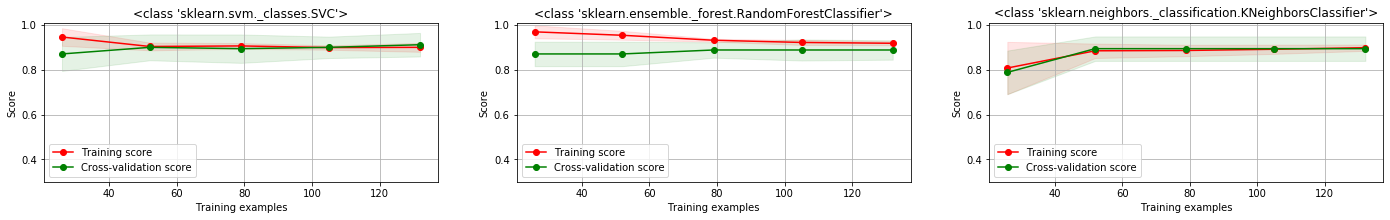

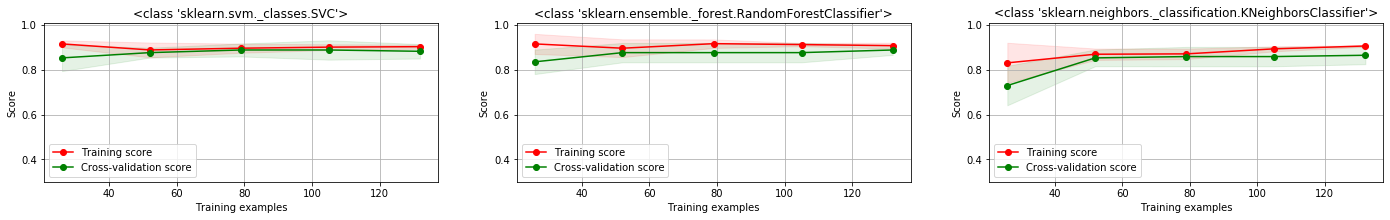

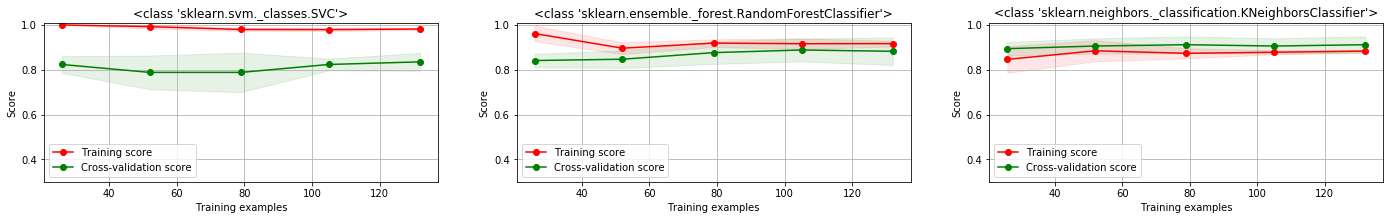

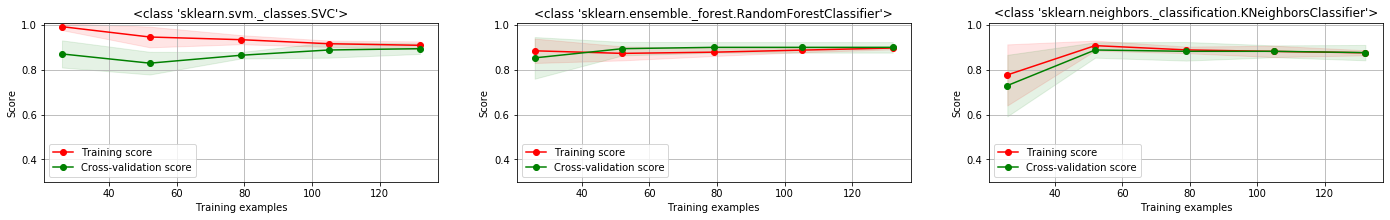

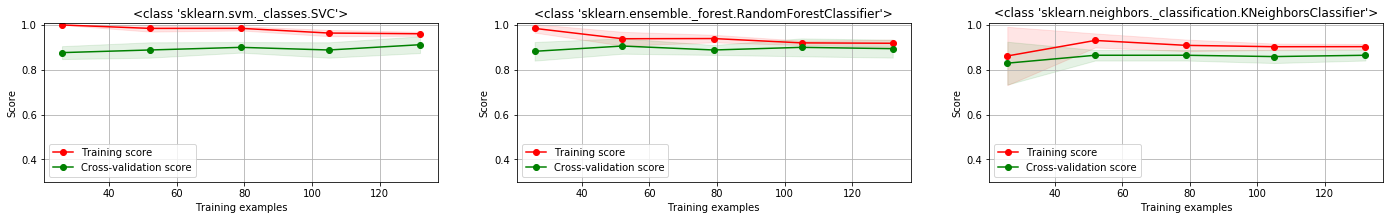

In [156]:

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

ACCURACIES_OUTER = list()
BALANCED_ACCURACIES_OUTER = list()
ROC_AUC_OUTER = list()
FEATURES_SELECTED_TOTAL = list()

fold = 0
ACCURACY = pd.DataFrame(columns=['SVM', 'RF', 'KNN'])
ACCURACY_BALANCED = pd.DataFrame(columns=['SVM', 'RF', 'KNN'])
AUC = pd.DataFrame(columns=['SVM', 'RF', 'KNN'])

for train_index, test_index in skf.split(DATA_FEAT_SEL, LABELS_SEL):
    fold += 1 
    print(f'\n \n Run {fold} of outer crossvalidation')
    X_train, X_test = np.array(DATA_FEAT_SEL)[train_index], np.array(DATA_FEAT_SEL)[test_index]
    y_train, y_test = np.array(LABELS_SEL)[train_index], np.array(LABELS_SEL)[test_index]

    gbm_train = X_train[y_train=='GBM']
    lgg_train = X_train[y_train=='LGG']

    # ---------------------------------- IMPUTATION -----------------------------------

    X_train_imp, X_test_imp = knn_impute_train_set(X_train, X_test)
 
    # ------------------------------------ SCALING ----------------------------------------
    X_train_scal, X_test_scal = scale_train_and_test_data(X_train_imp, X_test_imp)

    # ------------------------------------ FEATURE SELECTION -------------------------------
    #RFECV
    #selected_features = select_features_rfecv(X_train_scal, y_train)
    #X_train_sel = X_train_scal[:,selected_features]
    #X_test_sel = X_test_scal[:,selected_features]

    # Univariate and L1
    X_train_sel, X_test_sel, selected_indices = select_features_univariate(X_train_scal, y_train, X_test_scal)
    #X_train_sel, X_test_sel, selected_indices = select_features_L1(X_train_scal, y_train, X_test_scal)
    print(selected_indices)
    features_selected = list()
    for index in selected_indices:
        features_selected.append(DATA_FEAT_SEL.columns[index])
    FEATURES_SELECTED_TOTAL.append(features_selected)

    #X_train_sel, X_test_sel = pca_analysis(X_train_scal, X_test_scal)

    # -------------- INNER CROSSVALIDATION HYPERPARAMETERS---------------------------------
    svm_classifier = svm_randomized_search(X_train_sel, y_train)   

    rf_classifier = rf_randomized_search(X_train_sel, y_train)

    knn_classifier = knn_randomized_search(X_train_sel, y_train)

    clfs = [svm_classifier, rf_classifier, knn_classifier]
    clfs_names = ['SVM', 'RF', 'KNN']

    # ---------------- Train and Test classifier ------------------------------------------------
    acc_dict = dict()
    accuracy_total = list()

    bal_acc_dict = dict()
    bal_acc_total = list()

    roc_auc_score_dict = dict()
    roc_auc_score_total = list()

    for clf, name in zip(clfs, clfs_names):
        acc_dict[name], bal_acc_dict[name], roc_auc_score_dict[name] = get_performance_classifier(clf, X_train_sel, y_train, X_test_sel, y_test)

    accuracy_total.append(acc_dict)
    bal_acc_total.append(bal_acc_dict)
    roc_auc_score_total.append(roc_auc_score_dict)
    
    ACCURACY = ACCURACY.append(acc_dict, ignore_index=True)
    ACCURACY_BALANCED = ACCURACY_BALANCED.append(bal_acc_dict, ignore_index=True)
    AUC = AUC.append(roc_auc_score_dict, ignore_index=True)

    print(f'Regular accuracy: \n {acc_dict}')
    print(f'Balanced accuracy: \n {bal_acc_dict}')
    print(f'Roc auc score: \n {roc_auc_score_dict}')

    ACCURACIES_OUTER.append(accuracy_total)
    BALANCED_ACCURACIES_OUTER.append(bal_acc_total)
    ROC_AUC_OUTER.append(roc_auc_score_total)

    #-------------------- LEARNING CURVES --------------------------------------------------
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=None)
    num = 0
    fig = plt.figure(figsize=(24,8*len(clfs)))
    X_total = np.concatenate((X_train_sel, X_test_sel), axis=0)
    y_total = np.concatenate([y_train, y_test])
    
    for clf in clfs:
        title = str(type(clf))
        ax = fig.add_subplot(7, 3, num+1)
        plot_learning_curve(clf, title, X_total, y_total, ax, ylim=(0.3, 1.01), cv=cv, train_sizes=np.linspace(0.2,                             1,5))
        num += 1


Performance of classifiers

In [157]:

MEAN_ACC = ACCURACY.mean()
print(f'The mean accuracy per classifier is: \n{MEAN_ACC}')
MEAN_ACC_BAL = ACCURACY_BALANCED.mean()
print(f'The mean balanced accuracy per classifier is: \n{MEAN_ACC_BAL}')
MEAN_AUC = AUC.mean()
print(f'The mean AUC per classifier is: \n{MEAN_AUC}')

The mean accuracy per classifier is: 
SVM    0.873440
RF     0.867558
KNN    0.891444
dtype: float64
The mean balanced accuracy per classifier is: 
SVM    0.853571
RF     0.843187
KNN    0.871026
dtype: float64
The mean AUC per classifier is: 
SVM    0.937521
RF     0.938694
KNN    0.918407
dtype: float64
